In [1]:
# Built-in
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scikit-learn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)

In [2]:
# Define the path to the dataset
base_path =  r'C:\Users\3\Desktop\Dataset\celeb_df_crop'
categories = ['fake', 'real']

# Initialize a list to hold data
data = []

# Process each category
for category in categories:
    category_path = os.path.join(base_path, category)
    for filename in os.listdir(category_path):
        if filename.endswith('.jpg'):
            try:
                id_part, frame_part = filename.split('_frame_')
                id_ = id_part.split('_')[0]
                frame = frame_part.split('.')[0]
                data.append({
                    'filename': filename,
                    'path': os.path.join(category_path, filename),
                    'id': int(id_),
                    'frame': int(frame),
                    'label': category
                })
            except ValueError:
                continue

# Convert the data to a DataFrame
df = pd.DataFrame(data)
df['label_id'] = df['label'].map({'fake': 0, 'real': 1})
df

df['video_key'] = df['id'].astype(str) + "_" + df['label']

from collections import defaultdict

video_dict = defaultdict(list)
labels = {}

for _, row in df.iterrows():
    key = row['video_key']
    video_dict[key].append(row['path'])
    labels[key] = row['label_id']



In [3]:
df

,filename,path,id,frame,label,label_id,video_key
0,000_id0_0000_frame_0000.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,0,fake,0,0_fake
1,000_id0_0000_frame_0001.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,1,fake,0,0_fake
2,000_id0_0000_frame_0002.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,2,fake,0,0_fake
3,000_id0_0000_frame_0003.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,3,fake,0,0_fake
4,000_id0_0000_frame_0004.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\fake\...,0,4,fake,0,0_fake
...,...,...,...,...,...,...,...
32367,541_id9_0009_frame_0025.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,25,real,1,541_real
32368,541_id9_0009_frame_0026.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,26,real,1,541_real
32369,541_id9_0009_frame_0027.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,27,real,1,541_real
32370,541_id9_0009_frame_0028.jpg,C:\Users\3\Desktop\Dataset\celeb_df_crop\real\...,541,28,real,1,541_real


In [6]:
# ================================================
# ĐỌC CSV FUSION: FFT + DCT + SRM + OPENFACE
# THAY THẾ CHO CSV OPENFACE CŨ
# ================================================
from sklearn.preprocessing import StandardScaler

print("📂 Loading merged FFT + DCT + SRM + OpenFace features from CSV files...")

# ĐƯỜNG DẪN FUSION CSV
csv_fake_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-CELEB\merge_frequency_openface_features_fake.csv'
csv_real_path = r'C:\Users\3\Desktop\Dataset\Fusion-frequency-openface-CELEB\merge_frequency_openface_features_real.csv'

# Kiểm tra tồn tại
if not os.path.exists(csv_fake_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_fake_path}")
if not os.path.exists(csv_real_path):
    raise FileNotFoundError(f"Không tìm thấy file: {csv_real_path}")

# Đọc 2 file CSV fake / real
df_fake_features = pd.read_csv(csv_fake_path)
df_real_features = pd.read_csv(csv_real_path)

# Gộp chung
df_all_features = pd.concat([df_fake_features, df_real_features], ignore_index=True)

# Đảm bảo cột filename đúng tên
df_all_features.rename(columns={df_all_features.columns[0]: 'filename'}, inplace=True)

# Các cột metadata KHÔNG đưa vào vector feature
non_feature_cols = [
    'filename',
    'width', 'height', 'color_mode', 'resize_to', 'do_hann'
]
non_feature_cols = [c for c in non_feature_cols if c in df_all_features.columns]

# Tất cả cột còn lại là feature: SRM + DCT + FFT + OpenFace (feature_1..feature_674, v.v.)
feature_cols = [c for c in df_all_features.columns if c not in non_feature_cols]

print(f"✅ Tổng số feature columns (SRM + DCT + FFT + OpenFace): {len(feature_cols)}")

# Tạo dict: filename -> vector feature (fusion)
csv_features = {}
for _, row in df_all_features.iterrows():
    filename = row['filename']
    feats = row[feature_cols].values.astype('float32')
    csv_features[filename] = feats

csv_feature_dim = len(feature_cols)
print(f"✅ Loaded {len(csv_features)} fused feature vectors")
print(f"✅ Each fused vector has {csv_feature_dim} dimensions")
print(f"✅ Feature dictionary ready for 1-to-1 frame mapping")



📂 Loading merged FFT + DCT + SRM + OpenFace features from CSV files...
✅ Tổng số feature columns (SRM + DCT + FFT + OpenFace): 958
✅ Loaded 16223 fused feature vectors
✅ Each fused vector has 958 dimensions
✅ Feature dictionary ready for 1-to-1 frame mapping


In [7]:
# ======================================================
# 3. IMPORT BỔ SUNG & CẤU HÌNH MÔ HÌNH
# ======================================================

import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import (
    Input, TimeDistributed, LSTM, Dropout, Dense, GlobalAveragePooling2D, 
    Concatenate, BatchNormalization, Bidirectional, Attention, Flatten
)
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from hmmlearn.hmm import GaussianHMM
from tfkan.layers import Conv2DKAN, DenseKAN
from scipy.stats import mode
from sklearn.preprocessing import StandardScaler

# Configuration (same as before)
video_keys = list(video_dict.keys())
video_labels = [labels[k] for k in video_keys]

img_size = (224, 224)
batch_size = 32
epochs = 50
n_splits = 5
sequence_len = 10
results = []
all_histories = []


In [8]:
# ======================================================
# 4. CHUẨN HÓA FUSION CSV FEATURES
# ======================================================

print("🔧 Computing CSV feature statistics for normalization...")
all_csv_features = []
for key in video_keys:
    frames = video_dict[key][:sequence_len]
    for path in frames:
        filename = os.path.basename(path)
        if filename in csv_features:
            all_csv_features.append(csv_features[filename])

if len(all_csv_features) == 0:
    raise RuntimeError("Không có mẫu nào khớp giữa tên file ảnh và CSV fusion (csv_features). Kiểm tra lại 'filename' trong CSV và folder ảnh.")

csv_scaler = StandardScaler()
csv_scaler.fit(all_csv_features)
print(f"✅ CSV feature normalization fitted on {len(all_csv_features)} samples")


🔧 Computing CSV feature statistics for normalization...
✅ CSV feature normalization fitted on 10840 samples


In [9]:
# ======================================================
# 5. DATA GENERATOR: VIDEOSEQUENCE
# ======================================================

class VideoSequence(tf.keras.utils.Sequence):
    def __init__(self, video_keys, video_dict, labels, batch_size, img_size, sequence_len=10, augment=False):
        self.video_keys = video_keys
        self.video_dict = video_dict
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.sequence_len = sequence_len
        self.augment = augment
        self.datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=15 if augment else 0,
            zoom_range=0.1 if augment else 0,
            horizontal_flip=augment
        )

    def __len__(self):
        return int(np.ceil(len(self.video_keys) / self.batch_size))

    def __getitem__(self, idx):
        batch_keys = self.video_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_X_img, batch_X_csv, batch_y = [], [], []

        for key in batch_keys:
            frames = self.video_dict[key][:self.sequence_len]
            imgs = []
            csv_feats = []
            
            for path in frames:
                # Load and process image
                img = cv2.imread(path)
                img = cv2.resize(img, self.img_size)
                img = self.datagen.random_transform(img) if self.augment else img
                img = img.astype('float32') / 255.0
                imgs.append(img)
                
                # Load FUSION CSV features (1-to-1 mapping)
                filename = os.path.basename(path)
                if filename in csv_features:
                    csv_feat = csv_features[filename]
                    csv_feat = csv_scaler.transform([csv_feat])[0]
                else:
                    csv_feat = np.zeros(csv_feature_dim, dtype='float32')
                csv_feats.append(csv_feat)
            
            # Pad sequences if needed
            while len(imgs) < self.sequence_len:
                imgs.append(np.zeros((*self.img_size, 3), dtype='float32'))
                csv_feats.append(np.zeros(csv_feature_dim, dtype='float32'))
            
            batch_X_img.append(imgs)
            batch_X_csv.append(csv_feats)
            batch_y.append(self.labels[key])

        return [np.array(batch_X_img), np.array(batch_X_csv)], np.array(batch_y)


In [10]:
# ======================================================
# 6. MÔ HÌNH BiLSTM + ATTENTION + KAN
# ======================================================

def build_model(sequence_len, img_size, csv_dim=674):
    # MobileNet branch
    base_cnn = MobileNetV2(input_shape=(*img_size, 3), include_top=False, weights='imagenet')
    base_cnn.trainable = True
    for layer in base_cnn.layers[:-20]:
        layer.trainable = False
    
    cnn_out = GlobalAveragePooling2D()(base_cnn.output)
    cnn_model = Model(inputs=base_cnn.input, outputs=cnn_out)
    
    # Image sequence input
    input_seq_img = Input(shape=(sequence_len, *img_size, 3), name='image_input')
    x_img = TimeDistributed(cnn_model)(input_seq_img)
    
    # CSV features input
    input_seq_csv = Input(shape=(sequence_len, csv_dim), name='csv_input')
    
    # BatchNormalization before fusion
    x_img = BatchNormalization(name='bn_mobilenet')(x_img)
    x_csv = BatchNormalization(name='bn_csv')(input_seq_csv)
    
    # Concatenate features (1-to-1 fusion)
    x_combined = Concatenate(axis=-1, name='feature_fusion')([x_img, x_csv])
    
    # BiLSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True, name='bilstm_1'))(x_combined)
    x = Dropout(0.3, name='dropout_1')(x)
    x = Bidirectional(LSTM(64, return_sequences=True, name='bilstm_2'))(x)
    x = Dropout(0.3, name='dropout_2')(x)
    
    # Attention mechanism
    attn_output = Attention(name='attention')([x, x])
    # Global average pooling over time dimension to get fixed-size output
    x = tf.keras.layers.GlobalAveragePooling1D(name='global_avg_pool')(attn_output)
    x = Dropout(0.2, name='dropout_attention')(x)
    
    # Classification layers
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(0.2, name='dropout_3')(x)
    x = Dense(32, activation='relu', name='dense_2')(x)
    x = Dropout(0.2, name='dropout_4')(x)
    
    # KAN output layer
    x = DenseKAN(1, name='kan_output')(x)
    output = tf.keras.activations.sigmoid(x)
    
    model = Model(inputs=[input_seq_img, input_seq_csv], outputs=output, name='BiLSTM_Attention_KAN')
    return model

# ======================================================
# 7. HMM POST-PROCESSING
# ======================================================

def hmm_postprocess(pred_probs, y_true, n_states=2):
    pred_probs = pred_probs.reshape(-1, 1)
    hmm = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)
    hmm.fit(pred_probs)
    hidden_states = hmm.predict(pred_probs)

    mapping = {}
    for state in np.unique(hidden_states):
        indices = [i for i in range(len(hidden_states)) if hidden_states[i] == state]
        state_labels = [y_true[i] for i in indices]
        if len(state_labels) > 0:
            mapped_label = mode(state_labels, keepdims=True).mode[0]
        else:
            mapped_label = 0
        mapping[state] = mapped_label

    hmm_labels = np.array([mapping[s] for s in hidden_states])
    return hmm_labels

# ======================================================
# 8. TRAINING K-FOLD
# ======================================================

print("\n🚀 Starting BiLSTM + Attention + KAN Training:")
print("   ✅ Bidirectional LSTM (128 + 64 units)")
print("   ✅ Keras Attention mechanism (robust)")
print("   ✅ Normalized FUSION features (1-to-1 mapping)")
print("   ✅ MobileNet (last 20 layers trainable)")
print("   ✅ KAN output layer")
print("   ✅ HMM post-processing\n")

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (trainval_idx, test_idx) in enumerate(skf.split(video_keys, video_labels), 1):
    print(f"\n{'='*60}")
    print(f"📊 Fold {fold}/{n_splits} - BiLSTM_Attention_KAN")
    print(f"{'='*60}")

    trainval_keys = [video_keys[i] for i in trainval_idx]
    test_keys = [video_keys[i] for i in test_idx]

    y_trainval = [labels[k] for k in trainval_keys]
    train_keys, val_keys = train_test_split(
        trainval_keys,
        test_size=0.1,
        stratify=y_trainval,
        random_state=fold
    )

    train_gen = VideoSequence(
        train_keys, video_dict, labels,
        batch_size, img_size, sequence_len,
        augment=True
    )
    val_gen = VideoSequence(
        val_keys, video_dict, labels,
        batch_size, img_size, sequence_len,
        augment=False
    )
    test_gen = VideoSequence(
        test_keys, video_dict, labels,
        batch_size, img_size, sequence_len,
        augment=False
    )

    model = build_model(sequence_len, img_size, csv_feature_dim)
    model.compile(optimizer=Adamax(3e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    print(f"\n📈 Model Architecture:")
    print(f"   - Model: BiLSTM + Attention + KAN")
    print(f"   - Total params: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"   - Trainable params: {trainable_params:,}")
    print(f"   - Learning rate: 3e-4")

    model_path = f"best_model_fold{fold}_bilstm_attn_kan.h5"
    checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[checkpoint, earlystop, reduce_lr],
        verbose=1
    )
    all_histories.append(history.history)

    model.load_weights(model_path)

    y_true = [labels[k] for k in test_keys]
    y_pred_prob = model.predict(test_gen).ravel()
    y_hmm_pred = hmm_postprocess(y_pred_prob, y_true)

    results.append({
        'fold': fold,
        'accuracy': accuracy_score(y_true, y_hmm_pred),
        'precision': precision_score(y_true, y_hmm_pred),
        'recall': recall_score(y_true, y_hmm_pred),
        'f1': f1_score(y_true, y_hmm_pred),
        'auc': roc_auc_score(y_true, y_pred_prob)
    })
    
    print(f"\n✅ Fold {fold} Results (BiLSTM_Attention_KAN):")
    print(f"   Accuracy:  {results[-1]['accuracy']:.4f}")
    print(f"   Precision: {results[-1]['precision']:.4f}")
    print(f"   Recall:    {results[-1]['recall']:.4f}")
    print(f"   F1 Score:  {results[-1]['f1']:.4f}")
    print(f"   AUC:       {results[-1]['auc']:.4f}")

print(f"\n{'='*60}")
print("📊 FINAL RESULTS - BiLSTM_Attention_KAN Model")
print(f"{'='*60}")
for r in results:
    print(f"Fold {r['fold']}: Acc={r['accuracy']:.4f}, "
          f"Prec={r['precision']:.4f}, Rec={r['recall']:.4f}, "
          f"F1={r['f1']:.4f}, AUC={r['auc']:.4f}")

print(f"\n📊 Average Metrics:")
results_df = pd.DataFrame(results)
print(results_df.mean(numeric_only=True))


🚀 Starting BiLSTM + Attention + KAN Training:
   ✅ Bidirectional LSTM (128 + 64 units)
   ✅ Keras Attention mechanism (robust)
   ✅ Normalized FUSION features (1-to-1 mapping)
   ✅ MobileNet (last 20 layers trainable)
   ✅ KAN output layer
   ✅ HMM post-processing


📊 Fold 1/5 - BiLSTM_Attention_KAN



📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,866,105
   - Trainable params: 3,809,341
   - Learning rate: 3e-4
Epoch 1/50


25/25 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5282
Epoch 1: val_accuracy improved from -inf to 0.56322, saving model to best_model_fold1_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 151s 6s/step - loss: 0.6826 - accuracy: 0.5282 - val_loss: 0.6898 - val_accuracy: 0.5632 - lr: 3.0000e-04
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6885
Epoch 2: val_accuracy did not improve from 0.56322
25/25 [==============================] - 134s 5s/step - loss: 0.6070 - accuracy: 0.6885 - val_loss: 0.6899 - val_accuracy: 0.4943 - lr: 3.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5101 - accuracy: 0.8244
Epoch 3: val_accuracy did not improve from 0.56322
25/25 [==============================] - 133s 5s/step - loss: 0.5101 - accuracy: 0.8244 - val_loss: 0.6821 - val_accuracy: 0.5402 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8821
Epoch 4: val_accuracy did not improve from 0.56322
25/25 [==============================] - 132s 5s/step - loss: 0.4104 - accuracy: 0.8821 - val_loss: 0.7006 - val_accuracy: 0

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 132s 5s/step - loss: 0.3317 - accuracy: 0.9179 - val_loss: 0.6679 - val_accuracy: 0.5747 - lr: 3.0000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.2263 - accuracy: 0.9538
Epoch 6: val_accuracy improved from 0.57471 to 0.62069, saving model to best_model_fold1_bilstm_attn_kan.h5
25/25 [==============================] - 132s 5s/step - loss: 0.2263 - accuracy: 0.9538 - val_loss: 0.6481 - val_accuracy: 0.6207 - lr: 3.0000e-04
Epoch 7/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9615
Epoch 7: val_accuracy did not improve from 0.62069
25/25 [==============================] - 133s 5s/step - loss: 0.1676 - accuracy: 0.9615 - val_loss: 0.7433 - val_accuracy: 0.5977 - lr: 3.0000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1077 - accuracy: 0.9846
Epoch 8: val_accuracy improved from 0.62069 to 0.63218, saving model to best_model_fold1_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 132s 5s/step - loss: 0.1077 - accuracy: 0.9846 - val_loss: 0.8327 - val_accuracy: 0.6322 - lr: 3.0000e-04
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.0828 - accuracy: 0.9782
Epoch 9: val_accuracy did not improve from 0.63218

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 132s 5s/step - loss: 0.0828 - accuracy: 0.9782 - val_loss: 1.2519 - val_accuracy: 0.5862 - lr: 3.0000e-04
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9936
Epoch 10: val_accuracy did not improve from 0.63218
25/25 [==============================] - 132s 5s/step - loss: 0.0552 - accuracy: 0.9936 - val_loss: 1.5058 - val_accuracy: 0.5517 - lr: 1.5000e-04
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9962
Epoch 11: val_accuracy did not improve from 0.63218
25/25 [==============================] - 13

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6216 - accuracy: 0.7359
Epoch 2: val_accuracy improved from 0.49425 to 0.55172, saving model to best_model_fold2_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.6216 - accuracy: 0.7359 - val_loss: 0.6829 - val_accuracy: 0.5517 - lr: 3.0000e-04
Epoch 3/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.8205
Epoch 3: val_accuracy did not improve from 0.55172
25/25 [==============================] - 133s 5s/step - loss: 0.5229 - accuracy: 0.8205 - val_loss: 0.6973 - val_accuracy: 0.5287 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3767 - accuracy: 0.8897
Epoch 4: val_accuracy did not improve from 0.55172
25/25 [==============================] - 133s 5s/step - loss: 0.3767 - accuracy: 0.8897 - val_loss: 0.7457 - val_accuracy: 0.5517 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.2777 - accuracy: 0.9090
Epoch 5: val_accuracy improved from 0.55172 to 0.56322, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 132s 5s/step - loss: 0.2777 - accuracy: 0.9090 - val_loss: 0.8337 - val_accuracy: 0.5632 - lr: 3.0000e-04
E

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1985 - accuracy: 0.9449
Epoch 6: val_accuracy did not improve from 0.56322
25/25 [==============================] - 133s 5s/step - loss: 0.1985 - accuracy: 0.9449 - val_loss: 0.8949 - val_accuracy: 0.5402 - lr: 1.5000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.1527 - accuracy: 0.9603
Epoch 7: val_accuracy improved from 0.56322 to 0.58621, saving model to best_model_fold2_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.1527 - accuracy: 0.9603 - val_loss: 0.9482 - val_accuracy: 0.5862 - lr: 1.5000e-04
Epoch 8/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1153 - accuracy: 0.9756
Epoch 8: val_accuracy improved from 0.58621 to 0.62069, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 8: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 133s 5s/step - loss: 0.1153 - accuracy: 0.9756 - val_loss: 0.9103 - val_accuracy: 0.6207 - lr: 1.5000e-04
Epoch 9/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9731
Epoch 9: val_accuracy did not improve from 0.62069
25/25 [==============================] - 132s 5s/step - loss: 0.1024 - accuracy: 0.9731 - val_loss: 1.0534 - val_accuracy: 0.5862 - lr: 7.5000e-05
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0952 - accuracy: 0.9756
Epoch 10: val_accuracy did not improve from 0.62069
25/25 [==============================] - 132s 5s/step - loss: 0.0952 - accuracy: 0.9756 - val_loss: 1.0573 - val_accuracy: 0.6207 - lr: 7.5000e-05
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0821 - accuracy: 0.9795
Epoch 11: val_accuracy improved from 0.62069 to 0.63218, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 132s 5s/step - loss: 0.0821 - accuracy: 0.9795 - val_loss: 0.9768 - val_accuracy: 0.6322 - lr: 7.5000

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0733 - accuracy: 0.9846
Epoch 12: val_accuracy improved from 0.63218 to 0.64368, saving model to best_model_fold2_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.0733 - accuracy: 0.9846 - val_loss: 1.0013 - val_accuracy: 0.6437 - lr: 3.7500e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.0744 - accuracy: 0.9885
Epoch 13: val_accuracy did not improve from 0.64368
25/25 [==============================] - 132s 5s/step - loss: 0.0744 - accuracy: 0.9885 - val_loss: 1.0311 - val_accuracy: 0.6437 - lr: 3.7500e-05
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9910
Epoch 14: val_accuracy improved from 0.64368 to 0.66667, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 14: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 133s 5s/step - loss: 0.0609 - accuracy: 0.9910 - val_loss: 1.0328 - val_accuracy: 0.6667 - lr: 3.7500e-05
Epoch 15/50
25/25 [==============================] - ETA: 0s - loss: 0.0593 - accuracy: 0.9897
Epoch 15: val_accuracy did not improve from 0.66667
25/25 [==============================] - 133s 5s/step - loss: 0.0593 - accuracy: 0.9897 - val_loss: 0.9985 - val_accuracy: 0.6667 - lr: 1.8750e-05
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.0565 - accuracy: 0.9923
Epoch 16: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold2_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0565 - accuracy: 0.9923 - val_loss: 0.9647 - val_accuracy: 0.6782 - lr: 1.8750e-05
Epoch 17/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9923
Epoch 17: val_accuracy improved from 0.67816 to 0.68966, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 17: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 133s 5s/step - loss: 0.0552 - accuracy: 0.9923 - val_loss: 0.9349 - val_accuracy: 0.6897 - lr: 1.8750e-05
Epoch 18/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0588 - accuracy: 0.9897
Epoch 18: val_accuracy improved from 0.68966 to 0.70115, saving model to best_model_fold2_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0588 - accuracy: 0.9897 - val_loss: 0.9107 - val_accuracy: 0.7011 - lr: 9.3750e-06


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.0602 - accuracy: 0.9885
Epoch 19: val_accuracy improved from 0.70115 to 0.73563, saving model to best_model_fold2_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 133s 5s/step - loss: 0.0602 - accuracy: 0.9885 - val_loss: 0.8766 - val_accuracy: 0.7356 - lr: 9.3750e-06
Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: 0.0536 - accuracy: 0.9949
Epoch 20: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 20: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 133s 5s/step - loss: 0.0536 - accuracy: 0.9949 - val_loss: 0.8524 - val_accuracy: 0.7471 - lr: 9.3750e-06
Epoch 21/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.9962
Epoch 21: val_accuracy did not improve from 0.74713
25/25 [==============================] - 133s 5s/step - loss: 0.0525 - accuracy: 0.9962 - val_loss: 0.8309 - val_accuracy: 0.7471 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9936
Epoch 22: val_accuracy improved from 0.74713 to 0.77011, saving model to best_model_fold2_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0518 - accuracy: 0.9936 - val_loss: 0.8085 - val_accuracy: 0.7701 - lr: 4.6875e-06
Epoch 23/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0514 - accuracy: 0.9936
Epoch 23: val_accuracy improved from 0.77011 to 0.78161, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 23: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 133s 5s/step - loss: 0.0514 - accuracy: 0.9936 - val_loss: 0.7937 - val_accuracy: 0.7816 - lr: 4.6875e-06
Epoch 24/50
25/25 [==============================] - ETA: 0s - loss: 0.0504 - accuracy: 0.9936
Epoch 24: val_accuracy did not improve from 0.78161
25/25 [==============================] - 132s 5s/step - loss: 0.0504 - accuracy: 0.9936 - val_loss: 0.7784 - val_accuracy: 0.7816 - lr: 2.3438e-06
Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9923
Epoch 25: val_accuracy did not improve from 0.78161
25/25 [==============================] - 132s 5s/step - loss: 0.0491 - accuracy: 0.9923 - val_loss: 0.7616 - val_accuracy: 0.7816 - lr: 2.3438e-06
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9936
Epoch 26: val_accuracy improved from 0.78161 to 0.79310, saving model to best_model_fold2_bilstm_attn_kan.h5

Epoch 26: ReduceLROnPlateau reducing learning rate to 1.1718

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0545 - accuracy: 0.9910
Epoch 27: val_accuracy did not improve from 0.79310
25/25 [==============================] - 133s 5s/step - loss: 0.0545 - accuracy: 0.9910 - val_loss: 0.7326 - val_accuracy: 0.7931 - lr: 1.1719e-06
Epoch 28/50
25/25 [==============================] - ETA: 0s - loss: 0.0564 - accuracy: 0.9885
Epoch 28: val_accuracy did not improve from 0.79310
25/25 [==============================] - 132s 5s/step - loss: 0.0564 - accuracy: 0.9885 - val_loss: 0.7163 - val_accuracy: 0.7931 - lr: 1.1719e-06
Epoch 29/50
25/25 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9923
Epoch 29: val_accuracy did not improve from 0.79310

Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-06.
25/25 [==============================] - 132s 5s/step - loss: 0.0503 - accuracy: 0.9923 - val_loss: 0.7012 - val_accuracy: 0.7931 - lr: 1.1719e-06
Epoch 30/50
25/25 [==============================] - ETA: 0s - loss:

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6121 - accuracy: 0.7359
Epoch 2: val_accuracy improved from 0.48276 to 0.50575, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.6121 - accuracy: 0.7359 - val_loss: 0.7474 - val_accuracy: 0.5057 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.8205
Epoch 3: val_accuracy improved from 0.50575 to 0.52874, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.4998 - accuracy: 0.8205 - val_loss: 0.8630 - val_accuracy: 0.5287 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3641 - accuracy: 0.8872
Epoch 4: val_accuracy did not improve from 0.52874

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 133s 5s/step - loss: 0.3641 - accuracy: 0.8872 - val_loss: 1.1143 - val_accuracy: 0.5287 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.9167
Epoch 5: val_accuracy did not improve from 0.52874
25/25 [==============================] - 133s 5s/step - loss: 0.2703 - accuracy: 0.9167 - val_loss: 1.2011 - val_accuracy: 0.5287 - lr: 1.5000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.2069 - accuracy: 0.9423
Epoch 6: val_accuracy improved from 0.52874 to 0.54023, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.2069 - accuracy: 0.9423 - val_loss: 1.2777 - val_accuracy: 0.5402 - lr: 1

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9641
Epoch 7: val_accuracy improved from 0.54023 to 0.55172, saving model to best_model_fold3_bilstm_attn_kan.h5

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 134s 5s/step - loss: 0.1647 - accuracy: 0.9641 - val_loss: 1.5738 - val_accuracy: 0.5517 - lr: 1.5000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1272 - accuracy: 0.9782
Epoch 8: val_accuracy improved from 0.55172 to 0.56322, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.1272 - accuracy: 0.9782 - val_loss: 1.5685 - val_accuracy: 0.5632 - lr: 7.5000e-05
Epoch 9/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.1088 - accuracy: 0.9808
Epoch 9: val_accuracy did not improve from 0.56322
25/25 [==============================] - 133s 5s/step - loss: 0.1088 - accuracy: 0.9808 - val_loss: 1.5944 - val_accuracy: 0.5632 - lr: 7.5000e-05
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.9833
Epoch 10: val_accuracy did not improve from 0.56322

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 132s 5s/step - loss: 0.0932 - accuracy: 0.9833 - val_loss: 1.6891 - val_accuracy: 0.5632 - lr: 7.5000e-05
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9885
Epoch 11: val_accuracy improved from 0.56322 to 0.58621, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0870 - accuracy: 0.9885 - val_loss: 1.6116 - val_accuracy: 0.5862 - lr: 3.7500

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0846 - accuracy: 0.9846
Epoch 12: val_accuracy did not improve from 0.58621
25/25 [==============================] - 134s 5s/step - loss: 0.0846 - accuracy: 0.9846 - val_loss: 1.6005 - val_accuracy: 0.5862 - lr: 3.7500e-05
Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.9885
Epoch 13: val_accuracy did not improve from 0.58621

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 132s 5s/step - loss: 0.0768 - accuracy: 0.9885 - val_loss: 1.5590 - val_accuracy: 0.5862 - lr: 3.7500e-05
Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9936
Epoch 14: val_accuracy did not improve from 0.58621
25/25 [==============================] - 132s 5s/step - loss: 0.0724 - accuracy: 0.9936 - val_loss: 1.5226 - val_accuracy: 0.5747 - lr: 1.8750e-05
Epoch 15/50
25/25 [==============================] 

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.9885
Epoch 17: val_accuracy did not improve from 0.63218
25/25 [==============================] - 134s 5s/step - loss: 0.0641 - accuracy: 0.9885 - val_loss: 1.3338 - val_accuracy: 0.6322 - lr: 9.3750e-06
Epoch 18/50
25/25 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9923
Epoch 18: val_accuracy did not improve from 0.63218
25/25 [==============================] - 132s 5s/step - loss: 0.0600 - accuracy: 0.9923 - val_loss: 1.2700 - val_accuracy: 0.6322 - lr: 9.3750e-06
Epoch 19/50
25/25 [==============================] - ETA: 0s - loss: 0.0697 - accuracy: 0.9885
Epoch 19: val_accuracy improved from 0.63218 to 0.66667, saving model to best_model_fold3_bilstm_attn_kan.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 133s 5s/step - loss: 0.0697 - accuracy: 0.9885 - val_loss: 1.2128 - val_accuracy: 0.6667 - lr: 9.3750

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0646 - accuracy: 0.9910
Epoch 20: val_accuracy improved from 0.66667 to 0.67816, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0646 - accuracy: 0.9910 - val_loss: 1.1620 - val_accuracy: 0.6782 - lr: 4.6875e-06


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9885
Epoch 21: val_accuracy improved from 0.67816 to 0.68966, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.0601 - accuracy: 0.9885 - val_loss: 1.1228 - val_accuracy: 0.6897 - lr: 4.6875e-06


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9923
Epoch 22: val_accuracy improved from 0.68966 to 0.70115, saving model to best_model_fold3_bilstm_attn_kan.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.
25/25 [==============================] - 133s 5s/step - loss: 0.0572 - accuracy: 0.9923 - val_loss: 1.0851 - val_accuracy: 0.7011 - lr: 4.6875e-06


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.0599 - accuracy: 0.9936
Epoch 23: val_accuracy improved from 0.70115 to 0.71264, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 132s 5s/step - loss: 0.0599 - accuracy: 0.9936 - val_loss: 1.0422 - val_accuracy: 0.7126 - lr: 2.3438e-06
Epoch 24/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0659 - accuracy: 0.9923
Epoch 24: val_accuracy improved from 0.71264 to 0.72414, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0659 - accuracy: 0.9923 - val_loss: 1.0040 - val_accuracy: 0.7241 - lr: 2.3438e-06
Epoch 25/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0534 - accuracy: 0.9962
Epoch 25: val_accuracy improved from 0.72414 to 0.73563, saving model to best_model_fold3_bilstm_attn_kan.h5

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.
25/25 [==============================] - 134s 5s/step - loss: 0.0534 - accuracy: 0.9962 - val_loss: 0.9728 - val_accuracy: 0.7356 - lr: 2.3438e-06
Epoch 26/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0583 - accuracy: 0.9936
Epoch 26: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold3_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 134s 5s/step - loss: 0.0583 - accuracy: 0.9936 - val_loss: 0.9370 - val_accuracy: 0.7471 - lr: 1.1719e-06
Epoch 27/50
25/25 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9936
Epoch 27: val_accuracy did not improve from 0.74713
25/25 [==============================] - 133s 5s/step - loss: 0.0624 - accuracy: 0.9936 - val_loss: 0.9042 - val_accuracy: 0.7471 - lr: 1.1719e-06
Epoch 28/50
25/25 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9949
Epoch 28: val_accuracy improved from 0.74713 to 0.77011, saving model to best_model_fold3_bilstm_attn_kan.h5

Epoch 28: ReduceLROnPlateau reducing learning rate to 1e-06.


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 133s 5s/step - loss: 0.0612 - accuracy: 0.9949 - val_loss: 0.8740 - val_accuracy: 0.7701 - lr: 1.1719e-06
Epoch 29/50
25/25 [==============================] - ETA: 0s - loss: 0.0575 - accuracy: 0.9949
Epoch 29: val_accuracy did not improve from 0.77011
25/25 [==============================] - 132s 5s/step - loss: 0.0575 - accuracy: 0.9949 - val_loss: 0.8440 - val_accuracy: 0.7701 - lr: 1.0000e-06
Epoch 30/50
25/25 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9949
Epoch 30: val_accuracy improved from 0.77011 to 0.79310, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0584 - accuracy: 0.9949 - val_loss: 0.8164 - val_accuracy: 0.7931 - lr: 1.0000e-06
Epoch 31/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9910
Epoch 31: val_accuracy did not improve from 0.79310
25/25 [==============================] - 133s 5s/step - loss: 0.0628 - accuracy: 0.9910 - val_loss: 0.7894 - val_accuracy: 0.7931 - lr: 1.0000e-06
Epoch 32/50
25/25 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9936
Epoch 32: val_accuracy improved from 0.79310 to 0.80460, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.0541 - accuracy: 0.9936 - val_loss: 0.7643 - val_accuracy: 0.8046 - lr: 1.0000e-06


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 33/50
25/25 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9949
Epoch 33: val_accuracy improved from 0.80460 to 0.82759, saving model to best_model_fold3_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0562 - accuracy: 0.9949 - val_loss: 0.7418 - val_accuracy: 0.8276 - lr: 1.0000e-06
Epoch 34/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9962
Epoch 34: val_accuracy did not improve from 0.82759
25/25 [==============================] - 133s 5s/step - loss: 0.0580 - accuracy: 0.9962 - val_loss: 0.7199 - val_accuracy: 0.8276 - lr: 1.0000e-06
Epoch 35/50
25/25 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9962
Epoch 35: val_accuracy did not improve from 0.82759
25/25 [==============================] - 134s 5s/step - loss: 0.0562 - accuracy: 0.9962 - val_loss: 0.7012 - val_accuracy: 0.8046 - lr: 1.0000e-06
Epoch 36/50
25/25 [==============================] - ETA: 0s - loss: 0.0590 - accuracy: 0.9936
Epoch 36: val_accuracy did not improve from 0.82759
25/25 [==============================] - 133s 5s/step - loss: 0.0590 - accuracy: 0.9936 - val_loss: 0.6842 - val_accuracy: 0.8046 - lr: 1.0000e-06
Epoch 37/50
25/25 [==============================] - ETA: 0s - loss: 0.0572 - accuracy: 0.9949
Epoch 37: val_accuracy did not impr

Model is not converging.  Current: 246.4083635013706 is not greater than 246.5775087600081. Delta is -0.1691452586375135



✅ Fold 3 Results (BiLSTM_Attention_KAN):
   Accuracy:  0.8387
   Precision: 0.9302
   Recall:    0.7339
   F1 Score:  0.8205
   AUC:       0.9269

📊 Fold 4/5 - BiLSTM_Attention_KAN

📈 Model Architecture:
   - Model: BiLSTM + Attention + KAN
   - Total params: 4,866,105
   - Trainable params: 3,809,341
   - Learning rate: 3e-4
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.5526
Epoch 1: val_accuracy improved from -inf to 0.50575, saving model to best_model_fold4_bilstm_attn_kan.h5
25/25 [==============================] - 142s 5s/step - loss: 0.6827 - accuracy: 0.5526 - val_loss: 0.6910 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 2/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.6322 - accuracy: 0.7051
Epoch 2: val_accuracy improved from 0.50575 to 0.52874, saving model to best_model_fold4_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.6322 - accuracy: 0.7051 - val_loss: 0.6857 - val_accuracy: 0.5287 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.5420 - accuracy: 0.8090
Epoch 3: val_accuracy did not improve from 0.52874
25/25 [==============================] - 138s 5s/step - loss: 0.5420 - accuracy: 0.8090 - val_loss: 0.7009 - val_accuracy: 0.5172 - lr: 3.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8487
Epoch 4: val_accuracy did not improve from 0.52874
25/25 [==============================] - 138s 5s/step - loss: 0.4195 - accuracy: 0.8487 - val_loss: 0.7134 - val_accuracy: 0.5287 - lr: 3.0000e-04
Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.9026
Epoch 5: val_accuracy improved from 0.52874 to 0.58621, saving model to best_model_fold4_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.3058 - accuracy: 0.9026 - val_loss: 0.6463 - val_accuracy: 0.5862 - lr: 3.0000e-04
Epoch 6/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2124 - accuracy: 0.9359
Epoch 6: val_accuracy did not improve from 0.58621
25/25 [==============================] - 133s 5s/step - loss: 0.2124 - accuracy: 0.9359 - val_loss: 0.8814 - val_accuracy: 0.5402 - lr: 3.0000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9551
Epoch 7: val_accuracy improved from 0.58621 to 0.59770, saving model to best_model_fold4_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.1433 - accuracy: 0.9551 - val_loss: 0.8816 - val_accuracy: 0.5977 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9756
Epoch 8: val_accuracy improved from 0.59770 to 0.81609, saving model to best_model_fold4_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.1028 - accuracy: 0.9756 - val_loss: 0.4817 - val_accuracy: 0.8161 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9846
Epoch 9: val_accuracy did not improve from 0.81609
25/25 [==============================] - 133s 5s/step - loss: 0.0703 - accuracy: 0.9846 - val_loss: 0.6228 - val_accuracy: 0.7471 - lr: 3.0000e-04
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0553 - accuracy: 0.9872
Epoch 10: val_accuracy did not improve from 0.81609
25/25 [==============================] - 134s 5s/step - loss: 0.0553 - accuracy: 0.9872 - val_loss: 0.7191 - val_accuracy: 0.7356 - lr: 3.0000e-04
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9885
Epoch 11: val_accuracy did not improve from 0.81609

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 132s 5s/step - loss: 0.0428 - accuracy: 0.9885 - val_loss: 1.1827 - val_accuracy: 0.6322 - lr: 3.0000e-04
Epoch 12/50
25/25 [=======================

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 141s 5s/step - loss: 0.6848 - accuracy: 0.5583 - val_loss: 0.6995 - val_accuracy: 0.4483 - lr: 3.0000e-04
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.6248 - accuracy: 0.7439
Epoch 2: val_accuracy improved from 0.44828 to 0.48276, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.6248 - accuracy: 0.7439 - val_loss: 0.7087 - val_accuracy: 0.4828 - lr: 3.0000e-04
Epoch 3/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.5036 - accuracy: 0.8271
Epoch 3: val_accuracy improved from 0.48276 to 0.49425, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.5036 - accuracy: 0.8271 - val_loss: 0.7581 - val_accuracy: 0.4943 - lr: 3.0000e-04


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.3592 - accuracy: 0.8822
Epoch 4: val_accuracy improved from 0.49425 to 0.50575, saving model to best_model_fold5_bilstm_attn_kan.h5

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
25/25 [==============================] - 133s 5s/step - loss: 0.3592 - accuracy: 0.8822 - val_loss: 1.0454 - val_accuracy: 0.5057 - lr: 3.0000e-04
Epoch 5/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9283
Epoch 5: val_accuracy did not improve from 0.50575
25/25 [==============================] - 134s 5s/step - loss: 0.2474 - accuracy: 0.9283 - val_loss: 1.1475 - val_accuracy: 0.5057 - lr: 1.5000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9513
Epoch 6: val_accuracy did not improve from 0.50575
25/25 [==============================] - 134s 5s/step - loss: 0.1936 - accuracy: 0.9513 - val_loss: 1.2724 - val_accuracy: 0.5057 - lr: 1.5000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.1515 - accuracy: 0.9565
Epoch 7: val_accuracy did not improve from 0.50575

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
25/25 [==============================] - 133s 5s/step - loss: 0.1515 - accuracy: 0.9565 - val_loss: 1.3918 - val_accuracy: 0.5057 - lr: 1.5000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.1062 - accuracy: 0.9731
Epoch 9: val_accuracy improved from 0.52874 to 0.54023, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.1062 - accuracy: 0.9731 - val_loss: 1.4821 - val_accuracy: 0.5402 - lr: 7.5000e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9808
Epoch 10: val_accuracy improved from 0.54023 to 0.55172, saving model to best_model_fold5_bilstm_attn_kan.h5

Epoch 10: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.
25/25 [==============================] - 135s 5s/step - loss: 0.0916 - accuracy: 0.9808 - val_loss: 1.5406 - val_accuracy: 0.5517 - lr: 7.5000e-05
Epoch 11/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9859
Epoch 11: val_accuracy improved from 0.55172 to 0.56322, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 134s 5s/step - loss: 0.0795 - accuracy: 0.9859 - val_loss: 1.5268 - val_accuracy: 0.5632 - lr: 3.7500e-05
Epoch 12/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9821
Epoch 12: val_accuracy improved from 0.56322 to 0.57471, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0797 - accuracy: 0.9821 - val_loss: 1.5203 - val_accuracy: 0.5747 - lr: 3.7500e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 13/50
25/25 [==============================] - ETA: 0s - loss: 0.0691 - accuracy: 0.9872
Epoch 13: val_accuracy improved from 0.57471 to 0.59770, saving model to best_model_fold5_bilstm_attn_kan.h5

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.
25/25 [==============================] - 133s 5s/step - loss: 0.0691 - accuracy: 0.9872 - val_loss: 1.5266 - val_accuracy: 0.5977 - lr: 3.7500e-05


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 14/50
25/25 [==============================] - ETA: 0s - loss: 0.0675 - accuracy: 0.9872
Epoch 14: val_accuracy did not improve from 0.59770
25/25 [==============================] - 134s 5s/step - loss: 0.0675 - accuracy: 0.9872 - val_loss: 1.5179 - val_accuracy: 0.5977 - lr: 1.8750e-05
Epoch 15/50
25/25 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9872
Epoch 15: val_accuracy did not improve from 0.59770
25/25 [==============================] - 133s 5s/step - loss: 0.0670 - accuracy: 0.9872 - val_loss: 1.4647 - val_accuracy: 0.5977 - lr: 1.8750e-05
Epoch 16/50
25/25 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9846
Epoch 16: val_accuracy did not improve from 0.59770

Epoch 16: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.
25/25 [==============================] - 134s 5s/step - loss: 0.0664 - accuracy: 0.9846 - val_loss: 1.4157 - val_accuracy: 0.5977 - lr: 1.8750e-05
Epoch 17/50
25/25 [=====================

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 134s 5s/step - loss: 0.0643 - accuracy: 0.9859 - val_loss: 1.3775 - val_accuracy: 0.6207 - lr: 9.3750e-06
Epoch 18/50
25/25 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9923
Epoch 18: val_accuracy improved from 0.62069 to 0.64368, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0524 - accuracy: 0.9923 - val_loss: 1.3310 - val_accuracy: 0.6437 - lr: 9.3750e-06
Epoch 19/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9898
Epoch 19: val_accuracy improved from 0.64368 to 0.65517, saving model to best_model_fold5_bilstm_attn_kan.h5

Epoch 19: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.
25/25 [==============================] - 133s 5s/step - loss: 0.0606 - accuracy: 0.9898 - val_loss: 1.3066 - val_accuracy: 0.6552 - lr: 9.3750e-06
Epoch 20/50


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9923
Epoch 20: val_accuracy did not improve from 0.65517
25/25 [==============================] - 132s 5s/step - loss: 0.0554 - accuracy: 0.9923 - val_loss: 1.2670 - val_accuracy: 0.6552 - lr: 4.6875e-06
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: 0.0512 - accuracy: 0.9949
Epoch 21: val_accuracy did not improve from 0.65517
25/25 [==============================] - 134s 5s/step - loss: 0.0512 - accuracy: 0.9949 - val_loss: 1.2312 - val_accuracy: 0.6552 - lr: 4.6875e-06
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: 0.0587 - accuracy: 0.9910
Epoch 22: val_accuracy improved from 0.65517 to 0.70115, saving model to best_model_fold5_bilstm_attn_kan.h5

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 134s 5s/step - loss: 0.0587 - accuracy: 0.9910 - val_loss: 1.1932 - val_accuracy: 0.7011 - lr: 4.6875e-06
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.0604 - accuracy: 0.9923
Epoch 23: val_accuracy did not improve from 0.70115
25/25 [==============================] - 133s 5s/step - loss: 0.0604 - accuracy: 0.9923 - val_loss: 1.1597 - val_accuracy: 0.7011 - lr: 2.3438e-06
Epoch 24/50
25/25 [==============================] - ETA: 0s - loss: 0.0521 - accuracy: 0.9936
Epoch 24: val_accuracy did not improve from 0.70115
25/25 [==============================] - 133s 5s/step - loss: 0.0521 - accuracy: 0.9936 - val_loss: 1.1285 - val_accuracy: 0.7011 - lr: 2.3438e-06
Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.0580 - accuracy: 0.9872
Epoch 25: val_accuracy did not improve from 0.70115

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.
25/25 [==============================] 

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9949
Epoch 27: val_accuracy did not improve from 0.71264
25/25 [==============================] - 132s 5s/step - loss: 0.0541 - accuracy: 0.9949 - val_loss: 1.0424 - val_accuracy: 0.7126 - lr: 1.1719e-06
Epoch 28/50
25/25 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9898
Epoch 28: val_accuracy did not improve from 0.71264

Epoch 28: ReduceLROnPlateau reducing learning rate to 1e-06.
25/25 [==============================] - 134s 5s/step - loss: 0.0562 - accuracy: 0.9898 - val_loss: 1.0147 - val_accuracy: 0.7126 - lr: 1.1719e-06
Epoch 29/50
25/25 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9898
Epoch 29: val_accuracy improved from 0.71264 to 0.72414, saving model to best_model_fold5_bilstm_attn_kan.h5
25/25 [==============================] - 133s 5s/step - loss: 0.0618 - accuracy: 0.9898 - val_loss: 0.9874 - val_accuracy: 0.7241 - lr: 1.0000e-06
Epoch 30/50

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - ETA: 0s - loss: 0.0547 - accuracy: 0.9923
Epoch 30: val_accuracy did not improve from 0.72414
25/25 [==============================] - 133s 5s/step - loss: 0.0547 - accuracy: 0.9923 - val_loss: 0.9619 - val_accuracy: 0.7241 - lr: 1.0000e-06
Epoch 31/50
25/25 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9923
Epoch 31: val_accuracy did not improve from 0.72414
25/25 [==============================] - 132s 5s/step - loss: 0.0530 - accuracy: 0.9923 - val_loss: 0.9383 - val_accuracy: 0.7241 - lr: 1.0000e-06
Epoch 32/50
25/25 [==============================] - ETA: 0s - loss: 0.0551 - accuracy: 0.9936
Epoch 32: val_accuracy did not improve from 0.72414
25/25 [==============================] - 133s 5s/step - loss: 0.0551 - accuracy: 0.9936 - val_loss: 0.9147 - val_accuracy: 0.7241 - lr: 1.0000e-06
Epoch 33/50
25/25 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9898
Epoch 33: val_accuracy improved fro

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 34/50
25/25 [==============================] - ETA: 0s - loss: 0.0538 - accuracy: 0.9923
Epoch 34: val_accuracy improved from 0.73563 to 0.74713, saving model to best_model_fold5_bilstm_attn_kan.h5


C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 133s 5s/step - loss: 0.0538 - accuracy: 0.9923 - val_loss: 0.8745 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 35/50
25/25 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9962
Epoch 35: val_accuracy did not improve from 0.74713
25/25 [==============================] - 132s 5s/step - loss: 0.0524 - accuracy: 0.9962 - val_loss: 0.8537 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 36/50
25/25 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9949
Epoch 36: val_accuracy did not improve from 0.74713
25/25 [==============================] - 132s 5s/step - loss: 0.0532 - accuracy: 0.9949 - val_loss: 0.8333 - val_accuracy: 0.7471 - lr: 1.0000e-06
Epoch 37/50
25/25 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9936
Epoch 37: val_accuracy did not improve from 0.74713
25/25 [==============================] - 134s 5s/step - loss: 0.0549 - accuracy: 0.9936 - val_loss: 0.8118 - val_accur

In [11]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.818267
precision    0.880330
recall       0.743459
f1           0.803141
auc          0.891184
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.811060,0.819048,0.796296,0.807512,0.864594
1,2,0.811060,0.935065,0.666667,0.778378,0.917686
2,3,0.838710,0.930233,0.733945,0.820513,0.926860
3,4,0.811060,0.820755,0.798165,0.809302,0.857119
4,5,0.819444,0.896552,0.722222,0.800000,0.889660


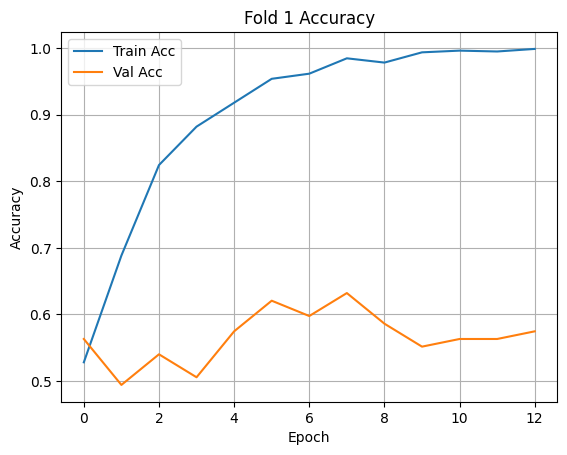

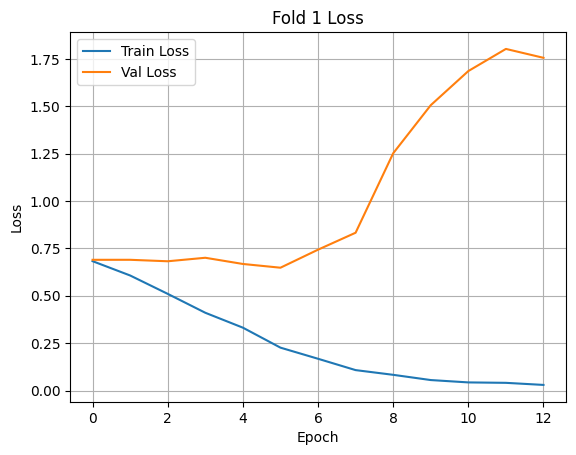

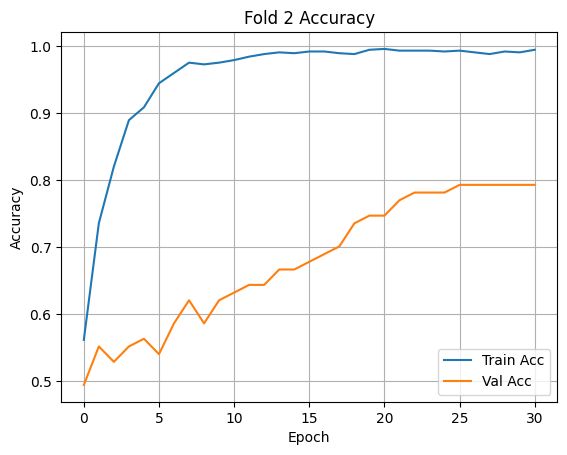

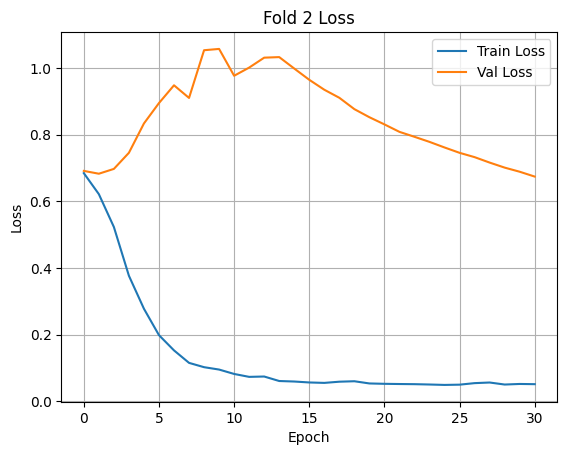

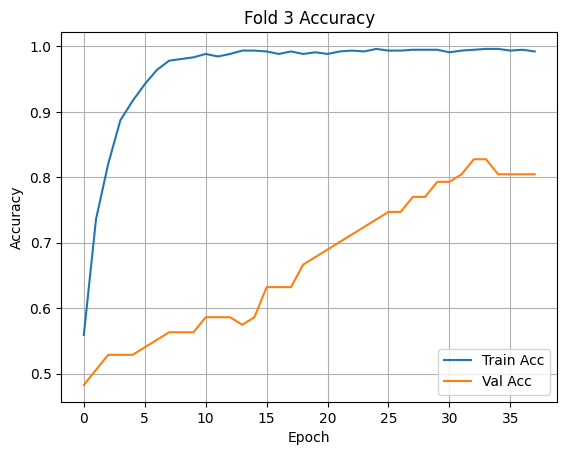

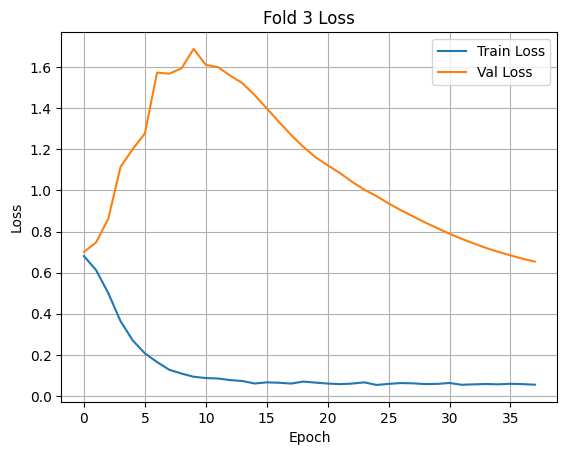

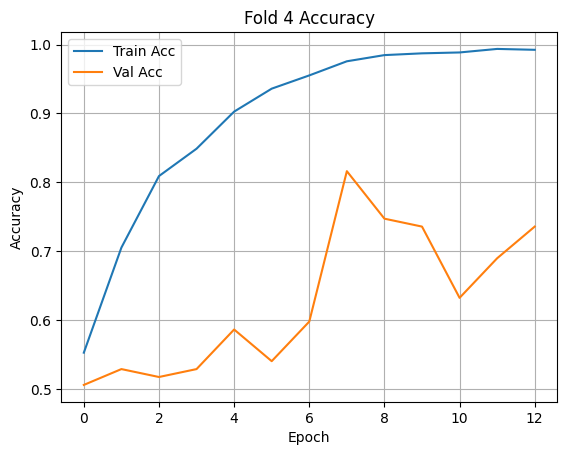

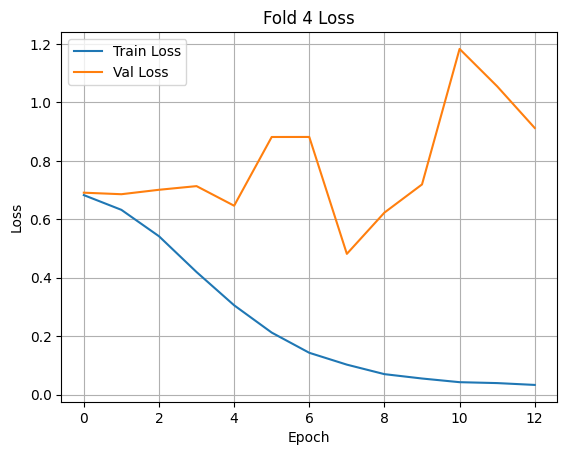

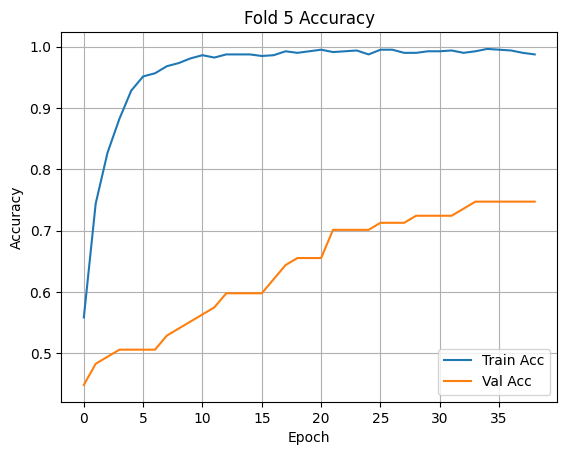

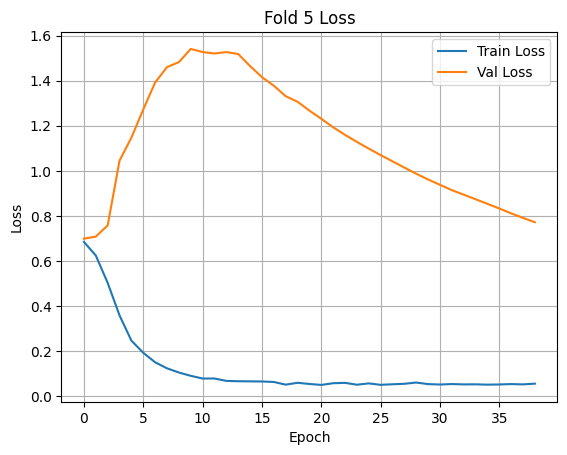

In [12]:
for i, hist in enumerate(all_histories, 1):
    plt.figure()
    plt.plot(hist['accuracy'], label='Train Acc')
    plt.plot(hist['val_accuracy'], label='Val Acc')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# Save mô hình fold cuối cùng
model.save("BiLSTM_Multi_Head_Attention_HMM_final.h5")

C:\Users\3\Desktop\DeepFake\.venv310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
results_df = pd.DataFrame(results)
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.818267
precision    0.880330
recall       0.743459
f1           0.803141
auc          0.891184
dtype: float64


,fold,accuracy,precision,recall,f1,auc
0,1,0.811060,0.819048,0.796296,0.807512,0.864594
1,2,0.811060,0.935065,0.666667,0.778378,0.917686
2,3,0.838710,0.930233,0.733945,0.820513,0.926860
3,4,0.811060,0.820755,0.798165,0.809302,0.857119
4,5,0.819444,0.896552,0.722222,0.800000,0.889660


In [15]:
import pandas as pd

# Giả sử results đã có và bạn đã tạo results_df
results_df = pd.DataFrame(results)

# Tính các chỉ số
accuracy_mean = results_df['accuracy'].mean()
accuracy_std = results_df['accuracy'].std()  # dùng sample std (chia cho n-1)
accuracy_range = results_df['accuracy'].max() - results_df['accuracy'].min()
accuracy_cv_percent = (accuracy_std / accuracy_mean) * 100

# In kết quả
print("📊 Kết quả trung bình:")
print(results_df.mean(numeric_only=True))

print(f"\n✅ CV Accuracy (Mean Accuracy): {accuracy_mean:.4f}")
print(f"📈 Range Accuracy: {accuracy_range:.4f}")
print(f"📉 Accuracy CV% (std/mean): {accuracy_cv_percent:.2f}%")

# Hiển thị bảng kết quả nếu cần
results_df

📊 Kết quả trung bình:
fold         3.000000
accuracy     0.818267
precision    0.880330
recall       0.743459
f1           0.803141
auc          0.891184
dtype: float64

✅ CV Accuracy (Mean Accuracy): 0.8183
📈 Range Accuracy: 0.0276
📉 Accuracy CV% (std/mean): 1.47%


,fold,accuracy,precision,recall,f1,auc
0,1,0.811060,0.819048,0.796296,0.807512,0.864594
1,2,0.811060,0.935065,0.666667,0.778378,0.917686
2,3,0.838710,0.930233,0.733945,0.820513,0.926860
3,4,0.811060,0.820755,0.798165,0.809302,0.857119
4,5,0.819444,0.896552,0.722222,0.800000,0.889660
